#  Compute the Fair Price of a Zero Coupon Treasury Bill

## Background
Treasury bills, or T-bills, are debt instruments with short-term maturity periods ranging from a few days to 52 weeks. T-bills are zero-coupon fixed-income investments, i.e., no coupon payments are paid during their term. Instead, treasury bills are priced so that the bill holder receives the par value $V_{P}$ at the end of the term. A zero-coupon T-bill with an annual market interest rate of $\bar{r}$, specified at the time of purchase, and a T-year term has the fair price:

$$
V_{B} = \frac{V_{P}}{\left(1+\bar{r}\right)^{T}}
$$

The fair price $V_{B}$ of the treasury bill is the future par value $V_{P}$ of the T-bill discounted to today by the market interest rate $\bar{r}$. Treasury bills are issued for specific periods, such as 4, 8, 13, 26, and 52 weeks.

## Example
Compute the fair price of 4-week and 52-week treasury bills using historical interest rate data gathered daily from 2019 to 2023:

1. Using the quoted annualized market interest rate $\bar{r}$, show that the fair price of a 52-week T-bill is more sensitive to changes in the interest rate than a 4-week T-bill with the same par value.
1. Using a binomial lattice model estimated from historical data, compute how the price of a 4-week and 52-week T-bill change between the time of purchase and the bond term.

## Setup
In the following code blocks we setup the computational aspects of the problem by including the `Include.jl` file. The `Include.jl` file loads external packages, functions that we will use in this excercise and custom types to model the components of our problem.

### Packages
`Include.jl` loads several external packages that we will use for our excercise:
* [DataFrames.jl](https://dataframes.juliadata.org/stable/) provides a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table and dplyr (in R)](https://dplyr.tidyverse.org), making it a great general purpose data science tool.

### Functions
`Include.jl` loads the [Julia functions](https://docs.julialang.org/en/v1/manual/functions/):

* The `loadratesfile(year::String = "2022") -> DataFrame` function takes a [String](https://docs.julialang.org/en/v1/manual/strings/) encoding the year in the `YYYY` format, e.g., `"2019"` or `"2020"` and returns a [DataFrame](https://dataframes.juliadata.org/stable/) holding the daily interest rates for US Treasury Bills for various durations found on [Treasury.gov](https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_bill_rates). This project has data from `"2019"`, `"2020"`, `"2021"`, `"2022"` and `"2022"`. The year parameter has a default value of `"2022"`.
* The `build(model::Type{MyUSTreasuryBillModel}, data::NamedTuple) -> MyUSTreasuryBillModel` function takes information in the `data` arguement (the par value, the rate and the duration of the T-bill) and returns an instance of the `MyUSTreasuryBillModel` custom type.

### Types
`Include.jl` loads some [problem specific types](https://docs.julialang.org/en/v1/manual/functions/) that will be helpful for the analysis of T-bill pricing. 

* `MyUSTreasuryBillModel` is a [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types) holding the par value $V_{P}$, the duration $T$ and the interest rate $\bar{r}$ for a zero-coupon treasury bill. You construct a `MyUSTreasuryBillModel` instance using the `build` method described above.

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-131/module-1`


## Prerequisite: Load and analyze historical interest rate data sets

In [2]:
rate_data_dictionary = Dict{String,DataFrame}();
years = ["2019","2020","2021","2022","2023"];
for year ∈ years
    rate_data_dictionary[year] = loadratesfile(year=year);
end

## Task 1: Compute $V_{B}$ for a 4-week and 52-week T-bill

In [11]:
# select a year to consider, must be 2019, 2020, 2021, 2022 or 2023
selected_year = "2020"
rate_data = rate_data_dictionary[selected_year];
Vₚ = 100.0;

#### Compute the fair price $V_{B}$ of 4-week T-bill

In [12]:
T = (4.0/52.0);

number_of_values = nrow(rate_data);
prices_4_weeks = Array{Float64,2}(undef, number_of_values, 3)
counter = 1;
for i ∈ number_of_values:-1:1
    
    # get the market interest rate from the data set 
    r̄ = rate_data[i,Symbol("4 WEEKS BANK DISCOUNT")];
    
    # compute the discount rate
    𝒟 = (1+r̄)^T;
    
    # compute the prices array
    prices_4_weeks[counter,1] = counter;
    prices_4_weeks[counter,2] = r̄;
    prices_4_weeks[counter,3] = (1/𝒟)*Vₚ
    
    # update the counter
    counter += 1
end

#### Compute the fair price $V_{B}$ of 52-week T-bill

In [13]:
T = (52.0/52.0);

number_of_values = nrow(rate_data);
prices_52_weeks = Array{Float64,2}(undef, number_of_values, 3)
counter = 1;
for i ∈ number_of_values:-1:1
    
    # get the market interest rate from the data set 
    r̄ = rate_data[i,Symbol("52 WEEKS BANK DISCOUNT")];
    
    # compute the discount rate
    𝒟 = (1+r̄)^T;
    
    # compute the prices array
    prices_52_weeks[counter,1] = counter;
    prices_52_weeks[counter,2] = r̄;
    prices_52_weeks[counter,3] = (1/𝒟)*Vₚ
    
     # update the counter
    counter += 1
end

#### Visualize the fair price $V_{B}$ as a function of the market interest rate

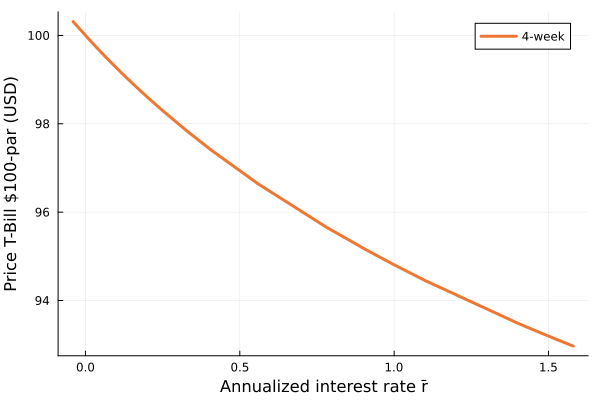

In [43]:
idx = sortperm(prices_4_weeks[:,2]);
plot(prices_4_weeks[idx,2], prices_4_weeks[idx,3],lw=3,c=colors[1],label="4-week", 
     xlabel="Annualized interest rate r̄", ylabel="Price T-Bill \$100-par (USD)")

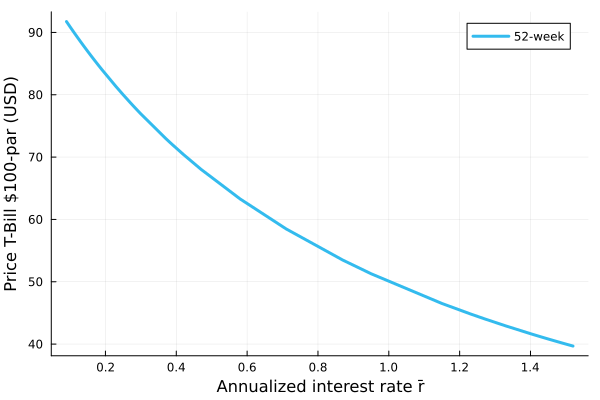

In [44]:
idx = sortperm(prices_52_weeks[:,2]);
plot(prices_52_weeks[idx,2], prices_52_weeks[idx,3],lw=3,c=colors[3],label="52-week", 
    xlabel="Annualized interest rate r̄", ylabel="Price T-Bill \$100-par (USD)")